### This is a Jupiter Notebook for the Capstone project of Applied Data Science specialisation on Coursera
Link: https://www.coursera.org/learn/applied-data-science-capstone/home/welcome

## 1. Introduction

In this project we attempt to build a machine learning based system that can predict severity of a car accident based on a variety of known attributes of an accident and conditions under which the accident has occurred. Severeity value is used to label an accident and split all accidents into categories based on a negative impact in terms of human fatalities, injuries, property damage, traffic delay or any other type of negative impact.

#### 1.1 Interest

Such system is of interest for insurance companies, police department traffic management divisions or any other party interested in analysing labeled incident data to make certain conclusions. Insurance companies could use derived severity data in insurance payments calculations. Police department could use labeled data to prioritise future work of improving road infrastructure to decrease the number of accidents in most accident-prone areas.


## 2. Data


#### 2.1 Dataset

As a dataset for building the prediction system collision records provided by Seattle Police Depratment have been used. Records contain a total of a little less than 200 000 records and span in a timeframe from 2004 till 2020. 

Dataset includes many types of collisions with attributes. Key attributes include such information as number of people and vehicles involved in an incident, weather and road conditions, reported violations that might have increased chances of a collision. Incidents are labeled by a severity code ranging from 1 (property damage) to 3 (fatality). 

Looking closer at the severity level in the provided dataset it is easy to determine, that only 2 values are present in records: severity level 1 (property damage) and severity level 2 (injury). Probable explaination for a lack of records with higher severity in the dataset could be sensitivity of such data, causing the authorities to filter such data out from the records available to the public.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import numpy as np

df = pd.read_csv('Data-Collisions.csv')
df.shape

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(194673, 38)

#### 2.2. Data cleaning

Looking closer at the data it becomes obvious, that dataset contains a lot of information not relevant for our analysis that can be removed. In particular: 

1. Columns containing various indentificators of an incident - OBJECTID, INCKEY, COLDETKEY, REPORTNO, INTKEY, SDOTCOLNUM, EXCEPTRSNCODE
2. Columns containing location data - X, Y, LOCATION, SEGLANEKEY, CROSSWALKKEY
3. Descriptions of label data - SEVERITYDESC, ST_COLDESC, EXCEPTRSNDESC, SDOT_COLDESC
4. Date and time data - INCDATE, INCDTTM
5. Severety label is duplicated in colums SEVERITYCODE and SEVERITYCODE.1, we can drop the latter one
6. STATUS columns is missing description in provided Metadata and is irrelevant for our analysis

In [47]:
columns_to_drop = [
    'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'INTKEY', 'SDOTCOLNUM', 'EXCEPTRSNCODE', #identifiers
    'X', 'Y', 'LOCATION', 'SEGLANEKEY', 'CROSSWALKKEY', #location
    'SEVERITYDESC', 'ST_COLDESC', 'EXCEPTRSNDESC', 'SDOT_COLDESC', #descriptions
    'INCDATE', 'INCDTTM', #date and time
    'SEVERITYCODE.1', #duplicated label
    'STATUS' #unknown purpose of this column
]
df.drop(columns=columns_to_drop, inplace=True)
df.shape

(194673, 18)

The following columns needed small fixing to replace missing values with a default value or to align values in the column:
1. INATTENTIONIND, PEDROWNOTGRNT, SPEEDING - replace NaNs with 0s, replace 'Y's with 1s
2. UNDERINFL, HITPARKEDCAR - replace 'N's with 0s, replace 'Y' with 1s
3. UNDERINFL - replace '1's with 1s and '0's with 0s

In [48]:
df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']] = df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING']].fillna(0)
df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING', 'UNDERINFL', 'HITPARKEDCAR']] = df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING', 'UNDERINFL', 'HITPARKEDCAR']].replace('N', 0)
df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING', 'UNDERINFL', 'HITPARKEDCAR']] = df[['INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING', 'UNDERINFL', 'HITPARKEDCAR']].replace('Y', 1)
df[['UNDERINFL']] = df[['UNDERINFL']].replace('0', 0)
df[['UNDERINFL']] = df[['UNDERINFL']].replace('1', 1)
df.shape

(194673, 18)

Finally we will drop all rows that contain 'Unknown' or NaN values in any of the columns

In [49]:
df.replace('Unknown', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(167840, 18)

In [17]:
df.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SPEEDING', 'ST_COLCODE', 'HITPARKEDCAR'],
      dtype='object')

#### 2.3. Balancing

The data present in the dataset is clearly unbalanced as indicated by the diagram below. There are 112367 cases of incidents with severity code of 1 (prop damage) and 55473 cases of indcidents with severity code of 2 (injury). The data contains more than twice as many less severe incidents.

1    112367
2     55473
Name: SEVERITYCODE, dtype: int64


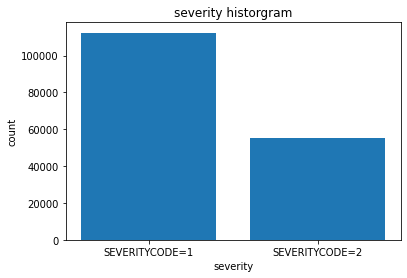

In [330]:
group_names = ['SEVERITYCODE=1', 'SEVERITYCODE=2']
pyplot.bar(group_names, df["SEVERITYCODE"].value_counts())
plt.xlabel("severity")
plt.ylabel("count")
plt.title("severity historgram")
print(df.SEVERITYCODE.value_counts())

In order to proceed with further data analysis and explorations we will first balance the dataset by using upsampling approach. In this approach the number of less frequent cases - cases with severity of 2 - will be randomly upsampled with replacement to match the number of more frequent cases - cases with severity of 1.

In [50]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]

 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

As seen by the diagram below, after upsampling we have an equal number of cases of both severity classes in consideration.

Text(0.5, 1.0, 'severity historgram balanced data')

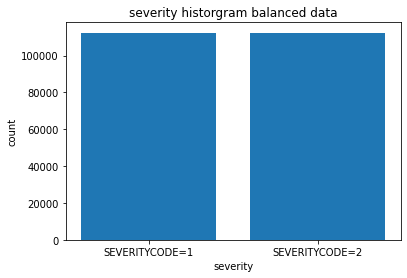

In [6]:
group_names = ['SEVERITYCODE=1', 'SEVERITYCODE=2']
pyplot.bar(group_names, df["SEVERITYCODE"].value_counts())
plt.xlabel("severity")
plt.ylabel("count")
plt.title("severity historgram balanced data")

## 3. Exploratory Data Analysis

### 3.1 Relation between number of people involved in the incident and severity

While there is no clear correlation between the number of persons involved in an incident (PERSONCOUNT feature) and the severity of an incident, there is a <b>clear direct correlation between the number of pedestrians and cyclists involved in an incident and the severity.</b> There are more incidents with severity level of 2 than with severity level of 1 when there is a least one pedestrian and/or at least one cyclist involved, as indicated by the histograms below.

<AxesSubplot:xlabel='PEDCYLCOUNT', ylabel='incidents'>

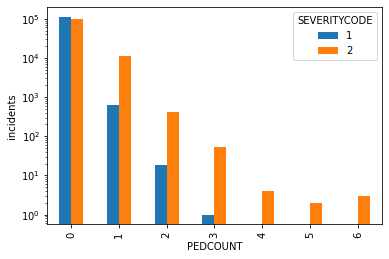

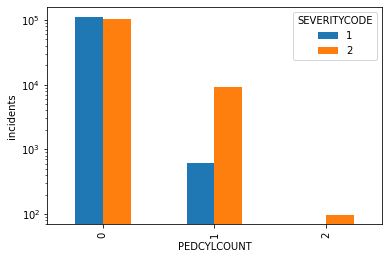

In [334]:
df[['PEDCOUNT', 'SEVERITYCODE']].groupby(['PEDCOUNT', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)
df[['PEDCYLCOUNT', 'SEVERITYCODE']].groupby(['PEDCYLCOUNT', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)


Looking at collision type data, the data confirms our hypothesis above. Collisions marked with the type "Cycles" and "Pedestrian" are very likely to be more severe than others.

<AxesSubplot:xlabel='COLLISIONTYPE', ylabel='incidents'>

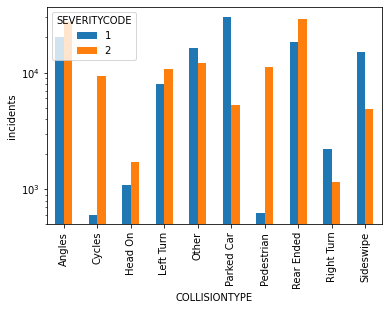

In [335]:
sev_by_col_type_count = df[['COLLISIONTYPE', 'SEVERITYCODE']].groupby(['COLLISIONTYPE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_col_type_count.plot(kind='bar', ylabel='incidents', logy=True)

### 3.2 Relation between number of vehicles involved in the incident and severity

If we look at the correlation between the number of vehicles involved in an incident and the severity of the incident, as with the case of person count, there seems to be no direct correlation. However there is one particular slice worth mentioning - a slice of incident data when the number of vehicles involved is 0. We can clearly see that in that slice there are a lot more incidents with severity of 2 than incidents with severity of 1. This confirms the observation we have already established, that when there are pedestrians and/or cyclists involved in the incident rather than just vehicles the consequences of such incident tend to me more severe.

<AxesSubplot:xlabel='VEHCOUNT', ylabel='incidents'>

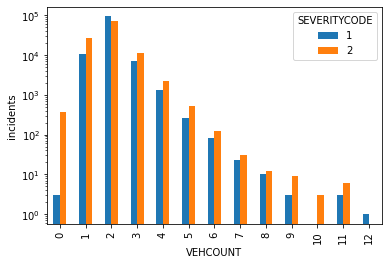

In [336]:
df[['VEHCOUNT', 'SEVERITYCODE']].groupby(['VEHCOUNT', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)

### 3.3 Relation between weather, road and light conditions and severity

After loooking at distribution of incidents severity based on weather, road and light condition there is no clear correleation that can be visibly established on the balanced dataset. Few ouliers in the data are incidents reported to have happened in partly cloudy weather and on the dark road with unknown lighting. Such incidents statistically tend to be more severe.

<AxesSubplot:xlabel='ROADCOND', ylabel='incidents'>

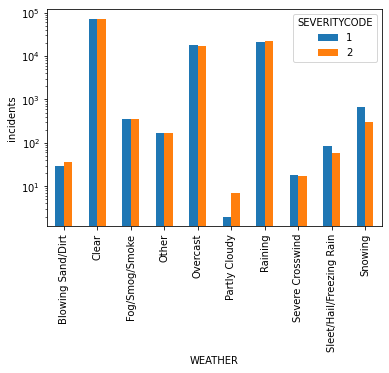

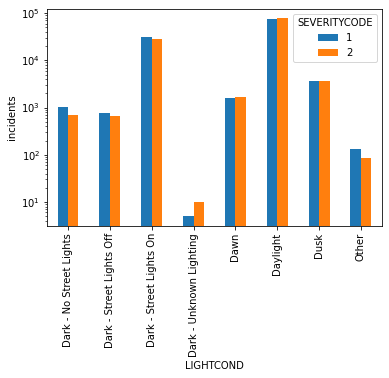

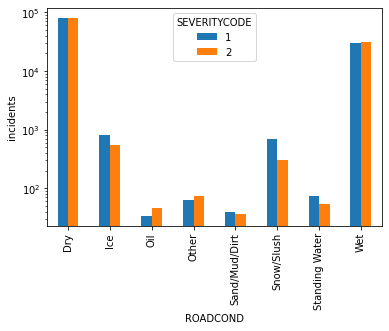

In [51]:
df[['WEATHER', 'SEVERITYCODE']].groupby(['WEATHER', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)
df[['LIGHTCOND', 'SEVERITYCODE']].groupby(['LIGHTCOND', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)
df[['ROADCOND', 'SEVERITYCODE']].groupby(['ROADCOND', 'SEVERITYCODE']).size().unstack(fill_value=0).plot(kind='bar', ylabel='incidents', logy=True)

### 3.4 Relation between wheather or not a parked car has been hit and severity

We can observe, that there are a lot more less severe incidents where a parked car has been reported to be hit than more severe. Hitting a paked car is therfore a good indicator of a less severe traffic incident.

<AxesSubplot:xlabel='HITPARKEDCAR', ylabel='incidents'>

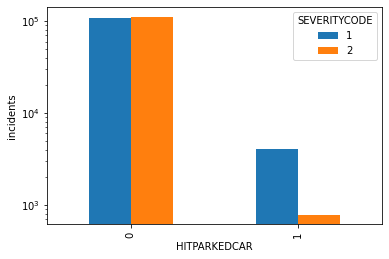

In [338]:
sev_by_hit_parked_car_count = df[['HITPARKEDCAR', 'SEVERITYCODE']].groupby(['HITPARKEDCAR', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_hit_parked_car_count.plot(kind='bar', ylabel='incidents', logy=True)

Same hypothesis is confirmed by looking at collision type data with collision type "Parked Car". We can see that there is an order of magnitude more less severe incidents of that type than more severe on the balanced dataset.

<AxesSubplot:xlabel='COLLISIONTYPE', ylabel='incidents'>

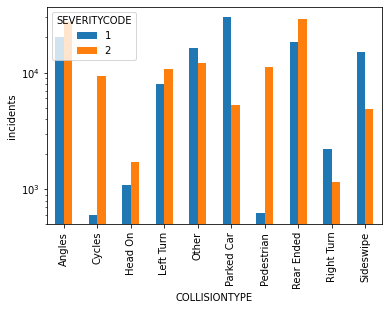

In [339]:
sev_by_col_type_count = df[['COLLISIONTYPE', 'SEVERITYCODE']].groupby(['COLLISIONTYPE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_col_type_count.plot(kind='bar', ylabel='incidents', logy=True)

### 3.5 Relation between wheather or not a pedestrian right of way has been granted and severity - strong direct correlation

Number of more severe incidents when a pedestrian right of way has not been granted is overwhelmingly higher than the number of less severe incident. Not giving a right of way is therefore is a good indicator of a more severe incident.

<AxesSubplot:xlabel='PEDROWNOTGRNT', ylabel='incidents'>

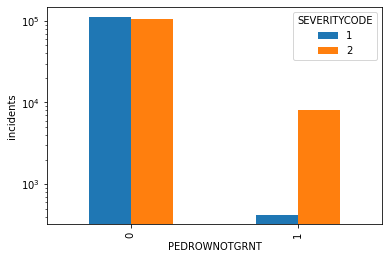

In [340]:
sev_by_ped_row_not_granted_count = df[['PEDROWNOTGRNT', 'SEVERITYCODE']].groupby(['PEDROWNOTGRNT', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_ped_row_not_granted_count.plot(kind='bar', ylabel='incidents', logy=True)

### 3.6 Relation between weather or not a driver was speeding and severity - slight direct correlation

When looking at speeding, inattention and driving under influence attributes of incidents we can establish, that all 3 of these characteristics have a slight positive correlation with incident's severity. 

<AxesSubplot:xlabel='UNDERINFL', ylabel='incidents'>

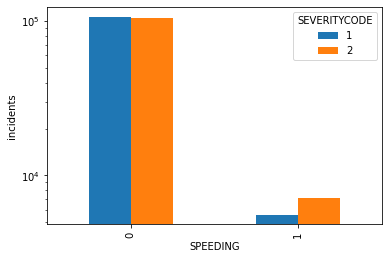

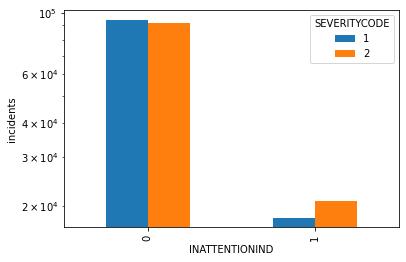

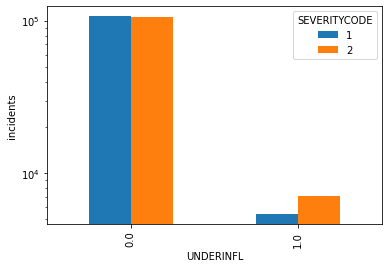

In [341]:
sev_by_speeding_count = df[['SPEEDING', 'SEVERITYCODE']].groupby(['SPEEDING', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_speeding_count.plot(kind='bar', ylabel='incidents', logy=True)

sev_by_inattention_ind_count = df[['INATTENTIONIND', 'SEVERITYCODE']].groupby(['INATTENTIONIND', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_inattention_ind_count.plot(kind='bar', ylabel='incidents', logy=True)

sev_by_under_infl_ind_count = df[['UNDERINFL', 'SEVERITYCODE']].groupby(['UNDERINFL', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_under_infl_ind_count.plot(kind='bar', ylabel='incidents', logy=True)

### 3.7 Relation between address type/junction type and severity

There seems to be no strong correlation between address type and junction type of an incident and severity level. One slice of data worth mentioning is the slice of incidents that occurred in the "Alley" address type. For that slice there is significantly more less severe incidents, which might be a good predictor for a severity within the model.

<AxesSubplot:xlabel='JUNCTIONTYPE', ylabel='incidents'>

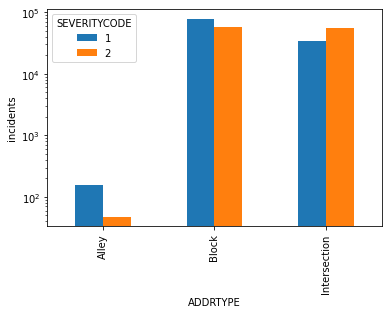

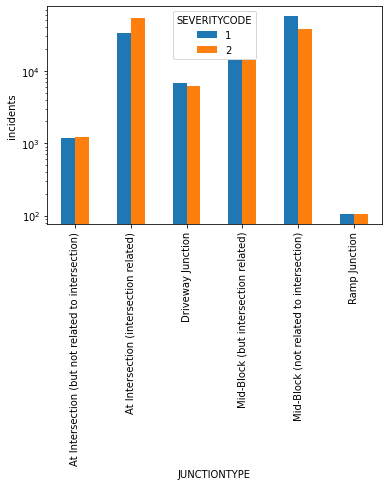

In [304]:
sev_by_addr_type_count = df[['ADDRTYPE', 'SEVERITYCODE']].groupby(['ADDRTYPE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_addr_type_count.plot(kind='bar', ylabel='incidents', logy=True)

sev_by_junct_type_count = df[['JUNCTIONTYPE', 'SEVERITYCODE']].groupby(['JUNCTIONTYPE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_junct_type_count.plot(kind='bar', ylabel='incidents', logy=True)

### 3.8 Relation between collision code and severity 

No clear correlation can be established between a collision code gived to an incident by the state or by SDOT and the severity of the incident. 

<AxesSubplot:xlabel='ST_COLCODE', ylabel='incidents'>

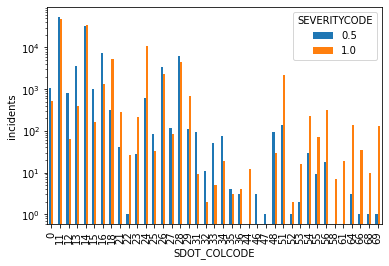

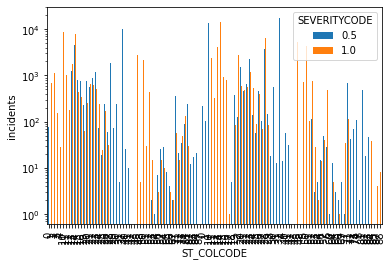

In [352]:
sev_by_sdot_code_count = df[['SDOT_COLCODE', 'SEVERITYCODE']].groupby(['SDOT_COLCODE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_sdot_code_count.plot(kind='bar', ylabel='incidents', logy=True)

sev_by_st_code_count = df[['ST_COLCODE', 'SEVERITYCODE']].groupby(['ST_COLCODE', 'SEVERITYCODE']).size().unstack(fill_value=0)
sev_by_st_code_count.plot(kind='bar', ylabel='incidents', logy=True)

## 4. Inferential statistics

### 4.1 Normalisation

First we normalise all numerical data so that values of dependent and independent variables range from 0 to 1.

In [6]:
df.SEVERITYCODE = df.SEVERITYCODE - 1
df.PEDCOUNT = df.PEDCOUNT/df.PEDCOUNT.max()
df.PEDCYLCOUNT = df.PEDCYLCOUNT/df.PEDCYLCOUNT.max()
df.VEHCOUNT = df.VEHCOUNT/df.VEHCOUNT.max()
df.PERSONCOUNT = df.PERSONCOUNT/df.PERSONCOUNT.max()

### 4.2 Indicator variables

Next we replace categorical feature columns with indicator variable columns, so that each possible class of each categorical feature translates into it's own column taking a value of 0 or 1. After having done that the dataset for training contains 206 features and 1 target variable we are trying to predict.

In [7]:
dummy_variable_addrtype = pd.get_dummies(df.ADDRTYPE, prefix="addr_")
dummy_variable_colltype = pd.get_dummies(df.COLLISIONTYPE, prefix="colltype_")
dummy_variable_junkttype = pd.get_dummies(df.JUNCTIONTYPE, prefix="junkttype_")
dummy_variable_weather = pd.get_dummies(df.WEATHER, prefix="weather_")
dummy_variable_road = pd.get_dummies(df.ROADCOND, prefix="road_")
dummy_variable_light = pd.get_dummies(df.LIGHTCOND, prefix="light_")
dummy_variable_st_code = pd.get_dummies(df.ST_COLCODE, prefix="stcode_")
dummy_variable_sdot_code = pd.get_dummies(df.SDOT_COLCODE, prefix="sdotcode_")

df_features = pd.concat(
    [
        df, 
        dummy_variable_addrtype, 
        dummy_variable_colltype, 
        dummy_variable_junkttype, 
        dummy_variable_weather, 
        dummy_variable_road, 
        dummy_variable_light, 
        dummy_variable_st_code, 
        dummy_variable_sdot_code
    ], 
    axis=1
)

columns_to_drop = ['ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'ST_COLCODE', 'SDOT_COLCODE']
df_features.drop(columns=columns_to_drop, inplace=True)
df_features.shape

(224734, 207)

### 4.3 Classification models

We split the dataset into features X and target variable Y. Both X and Y are then split into training data and test data with 75/25% split. Sample size was reduced to 10000 to increse model training time.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

sample = df_features.sample(n=10000, random_state=1)
X = sample.loc[:, sample.columns != 'SEVERITYCODE'].astype('float64')
Y = sample.SEVERITYCODE.astype('float64')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

The problem we are trying to solve here is a problem of classification: based on the values of feature vector we are trying to classify the value of target variable - severity of an incident. Since we did normalisation of data, target variable can be one of the two classes: 0 value corresponds to less severe incidents and 1 value corresponds to more severe. The following classifacion models have been applied and evaluated below, calculating logarithmic loss and accuracy as performance metrics: Support Vector Machines, Logistic Regression, Random Forest and Gradient Boosting.

In [13]:
model = svm.SVC(probability=True)
model.fit(X_train, Y_train)

Y_hat = model.predict(X_test)
Y_hat_prob = model.predict_proba(X_test)
CM = confusion_matrix(Y_test, Y_hat)

print('Accuracy: ' + str(accuracy_score(Y_test, Y_hat).round(3)))
print('Log Loss: ' + str(log_loss(Y_test, Y_hat_prob).round(3)))
print('True Negatives: ' + str(CM[0][0]))
print('False Negatives: ' + str(CM[1][0]))
print('True Positives: ' + str(CM[1][1]))
print('False Positives: ' + str(CM[0][1]))

Accuracy: 0.693
Log Loss: 0.601
True Negatives: 740
False Negatives: 251
True Positives: 993
False Positives: 516


In [14]:
model = LogisticRegression(random_state=0)
model.fit(X_train, Y_train)

Y_hat = model.predict(X_test)
Y_hat_prob = model.predict_proba(X_test)
CM = confusion_matrix(Y_test, Y_hat)

print('Accuracy: ' + str(accuracy_score(Y_test, Y_hat).round(3)))
print('Log Loss: ' + str(log_loss(Y_test, Y_hat_prob).round(3)))
print('True Negatives: ' + str(CM[0][0]))
print('False Negatives: ' + str(CM[1][0]))
print('True Positives: ' + str(CM[1][1]))
print('False Positives: ' + str(CM[0][1]))

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Accuracy: 0.694
Log Loss: 0.56
True Negatives: 764
False Negatives: 273
True Positives: 971
False Positives: 492


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

0.6835204047009119


/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [15]:
model = RandomForestClassifier(max_depth=2, random_state=0)
model.fit(X_train, Y_train)

Y_hat = model.predict(X_test)
Y_hat_prob = model.predict_proba(X_test)
CM = confusion_matrix(Y_test, Y_hat)

print('Accuracy: ' + str(accuracy_score(Y_test, Y_hat).round(3)))
print('Log Loss: ' + str(log_loss(Y_test, Y_hat_prob).round(3)))
print('True Negatives: ' + str(CM[0][0]))
print('False Negatives: ' + str(CM[1][0]))
print('True Positives: ' + str(CM[1][1]))
print('False Positives: ' + str(CM[0][1]))

Accuracy: 0.653
Log Loss: 0.642
True Negatives: 816
False Negatives: 428
True Positives: 816
False Positives: 440


In [16]:
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)

Y_hat = model.predict(X_test)
Y_hat_prob = model.predict_proba(X_test)
CM = confusion_matrix(Y_test, Y_hat)

print('Accuracy: ' + str(accuracy_score(Y_test, Y_hat).round(3)))
print('Log Loss: ' + str(log_loss(Y_test, Y_hat_prob).round(3)))
print('True Negatives: ' + str(CM[0][0]))
print('False Negatives: ' + str(CM[1][0]))
print('True Positives: ' + str(CM[1][1]))
print('False Positives: ' + str(CM[0][1]))

Accuracy: 0.699
Log Loss: 0.556
True Negatives: 774
False Negatives: 270
True Positives: 974
False Positives: 482


### 4.4 Performance of different models

Among applied models, gradient boosting showed the best performance on the dataset with an accuracy metric of 0.699. Below in the table is a detailed summary of performance metrics of different models that have been applied.

|                 |  SVM  | Log Reg | Random Forest | Gradient Boosting |
|-----------------|:-----:|:-------:|:-------------:|:-----------------:|
| Accuracy        | 0.693 |  0.694  |     0.653     |<b>0.699</b>       |
| Log Loss        | 0.601 |   0.56  |     0.642     |       0.556       |
| True Positives  |  993  |   971   |      816      |        974        |
| False Positives |  516  |   492   |      440      |        482        |
| True Negatives  |  740  |   764   |      816      |        774        |
| False Negatives |  251  |   273   |      428      |        270        |


## 5. Results

### 5.1 Conclusions

An exploratory analysis have been performed to identify statistical correlations between various factors and attributes of an incident and the severity of an incident. Based on the analysis the following factors have been identified as factors that increase the probability of a more severe incident the most:
- pedestrians involved
- cyclists involved
- partly cloudy weather 
- dark lighting
- pedestrian right of way not been granted
- speeding
- inattention
- driving under influence


A set of predictive models aimed at classifying an incident based on the known features has been built and measured in terms of performance. The model that showed the best performance on the test data is gradient boosting showing 0.699 accuracy.

### 5.2 Discussions

Conclusions and observations listed in this report might be further used in different ways by various intersted parties. Traffic control division of police department might release a statistics and concrete warning based on that statistics warning the drivers agains violations such as drivining under influence, violating speed limits or being inattentive while driving. Driving in bad weather or lighting conditions should be approached with special attention and caution. 

Predictive model built in the scope of this analysis can serve as a baseline for future work aimed at building a more accurate predictive system that would be able to calculate a certain coefficient indicating how dangerous the road conditions are at the moment, taking into account weather, road and lighting conditions, current segment of the road, real-time data from sensors about the surroundings etc. Such system when adapted for real time use could warn the driver in real time about the probability of an incident within the current conditions, asking therefore for more attention.